In [ ]:
!pip install matplotlib

In [1]:
from datetime import datetime
from matplotlib.dates import DateFormatter, MonthLocator
import matplotlib.pyplot as plt
import numpy as np

class ProjectDataProcessor:
    """Process data for latent heat flux comparison between FLUXNET and MODIS dataset"""
    
    def __init__(self, FLUXNET_file_path, MODIS_file_path):
        
        self.FLUXNET_file_path = FLUXNET_file_path
        self.MODIS_file_path = MODIS_file_path
        
        self.data_FLUXNET = {}
        self.data_MODIS = {}
        
        self.data = {}
        
        self._load_FLUXNET_data()
        self._load_MODIS_data()
        
        self._merge_datasets()
        self._compute_delta()
        
    
    def _load_FLUXNET_data(self):
        """Load latent heat flux data from FLUXNET dataset"""
        
        date_list = []
        value_list = []
        
        with open(self.FLUXNET_file_path, 'r', encoding='utf-8') as f:
            
            first_line = f.readline().split(',')
            ts_index = first_line.index('TIMESTAMP')
            le_index = first_line.index('LE_F_MDS')
            
            for line in f:
                line = line.split(',')
                date = datetime.strptime(line[ts_index], '%Y%m%d')
                value = line[le_index]
                date_list.append(date)
                value_list.append(float(value))
                
        for year in range(min(date_list).year, max(date_list).year + 1):
            self.data_FLUXNET[year] = {'dates':[], 'values':[]}
            
        for date, value in zip(date_list, value_list):
            self.data_FLUXNET[date.year]['dates'].append(date)
            self.data_FLUXNET[date.year]['values'].append(value)
            
            
    def _load_MODIS_data(self, pixel_number=145):
        """Load latent heat flux data from MODIS dataset"""
        
        date_list = []
        value_list = []
        
        with open(self.MODIS_file_path, 'r', encoding='utf-8') as f:
            
            for line in f:
                line = line.split(',')
                date = datetime.strptime(line[2], 'A%Y%j')
                value = line[5:][pixel_number - 1]
                
                if value != 'F':
                    date_list.append(date)
                    value_list.append((float(value) / (60*60*24)))
                    
        for year in range(min(date_list).year, max(date_list).year + 1):
            self.data_MODIS[year] = {'dates':[], 'values':[]}
            
        for date, value in zip(date_list, value_list):
            self.data_MODIS[date.year]['dates'].append(date)
            self.data_MODIS[date.year]['values'].append(value)
            
            
    def _merge_datasets(self):
        """Merge datasets into one dataset with only shared values"""
        
        for year in range(1990, 2030):
            if year in self.data_FLUXNET.keys() and year in self.data_MODIS.keys():
                self.data[year] = {'dates':[], 'values':{'FLUXNET':[], 'MODIS':[]}}
        
        for year in self.data.keys():
            
            for date, value in zip(self.data_MODIS[year]['dates'], self.data_MODIS[year]['values']):
                if date in self.data_FLUXNET[year]['dates']:
                    self.data[year]['dates'].append(date)
                    self.data[year]['values']['MODIS'].append(value)
            
            for date, value in zip(self.data_FLUXNET[year]['dates'], self.data_FLUXNET[year]['values']):
                if date in self.data_MODIS[year]['dates']:
                    # Create 8-day composite period for FLUXNET based on daily data
                    first_day_index = self.data_FLUXNET[year]['dates'].index(date)
                    last_day_index = self.data_FLUXNET[year]['dates'].index(date) + 8
                    eight_day_range = self.data_FLUXNET[year]['values'][first_day_index:last_day_index]
                    eight_day_sum = sum(eight_day_range)
                    eight_day_average = eight_day_sum / len(eight_day_range)
                    self.data[year]['values']['FLUXNET'].append(eight_day_average)
                    
                    
    def _compute_delta(self):
        """Compute absolute and relative deltas between datasets"""
        
        for year in self.data.keys():
            self.data[year]['deltas_abs'] = {'FLUXNET':[], 'MODIS':[]}
            self.data[year]['deltas_rel'] = {'FLUXNET':[], 'MODIS':[]}
            for f_value, m_value in zip(self.data[year]['values']['FLUXNET'], self.data[year]['values']['MODIS']):
                f_delta_abs = f_value - m_value
                m_delta_abs = m_value - f_value
                f_delta_rel = f_delta_abs / m_value
                m_delta_rel = m_delta_abs / f_value
                self.data[year]['deltas_abs']['FLUXNET'].append(f_delta_abs)
                self.data[year]['deltas_abs']['MODIS'].append(m_delta_abs)
                self.data[year]['deltas_rel']['FLUXNET'].append(f_delta_rel)
                self.data[year]['deltas_rel']['MODIS'].append(m_delta_rel)
                
            
    def plot_values(self, *years):
        """Plot latent heat flux data from FLUXNET and MODIS given any number of available years"""
        
        for year in years:
            if year not in self.data.keys():
                raise ValueError('Make sure all specified years are available in both datasets')
        
        fig, axs = plt.subplots(len(years), 1, figsize=(10, 5*len(years)))
                   
        for count, year in enumerate(years):
            x = self.data[year]['dates']
            
            y_f = self.data[year]['values']['FLUXNET']
            y_m = self.data[year]['values']['MODIS']
            
            if len(years) > 1:
                axs[count].plot(x, y_f, label='FLUXNET ' + str(year))
                axs[count].plot(x, y_m, label='MODIS ' + str(year))
                axs[count].set_xlim([datetime.strptime('1.1.'+str(year), '%d.%m.%Y'),
                                     datetime.strptime('31.12.'+str(year), '%d.%m.%Y')])
                axs[count].set_ylim(0, 200)
                axs[count].set_ylabel('Latent Heat Flux [W m-2]')
                axs[count].xaxis.set_major_locator(MonthLocator())
                axs[count].xaxis.set_major_formatter(DateFormatter('%b'))
                axs[count].set_title(year)
                axs[count].legend()
                
            else:
                axs.plot(x, y_f, label='FLUXNET ' + str(year))
                axs.plot(x, y_m, label='MODIS ' + str(year))
                axs.set_xlim([datetime.strptime('1.1.'+str(year), '%d.%m.%Y'),
                              datetime.strptime('31.12.'+str(year), '%d.%m.%Y')])
                axs.set_ylim(0, 200)
                axs.set_ylabel('Latent Heat Flux [W m-2]')
                axs.xaxis.set_major_locator(MonthLocator())
                axs.xaxis.set_major_formatter(DateFormatter('%b'))
                axs.set_title(year)
                axs.legend()
        
        plt.show()
        
        
    def plot_deltas(self, *years, mode='rel', base='FLUXNET'):
        """Plot delta of latent heat flux data from FLUXNET and MODIS given any number of available years"""
        
        if mode == 'abs':
            delta_type = 'deltas_abs'
            ylabel = 'Absolute Difference in Latent Heat Flux [W m-2]'
            ylim = (-100, 100)
        elif mode == 'rel':
            delta_type = 'deltas_rel'
            ylabel = 'Relative Difference in Latent Heat Flux [%]'
            ylim = (-200, 200)
        else:
            raise ValueError('Mode not valid')
        
        for year in years:
            if year not in self.data.keys():
                raise ValueError('Make sure all specified years are available in both datasets')
        
        fig, axs = plt.subplots(len(years), 1, figsize=(10, 5*len(years)))
                   
        for count, year in enumerate(years):
            x = self.data[year]['dates']
            
            y = np.array(self.data[year][delta_type][base])*100
            
            if len(years) > 1:
                axs[count].bar(x, y, width=8, color=np.where(np.array(y)>0, 'tab:blue', 'tab:orange'))
                axs[count].set_xlim([datetime.strptime('1.1.'+str(year), '%d.%m.%Y'),
                                     datetime.strptime('31.12.'+str(year), '%d.%m.%Y')])
                axs[count].set_ylim(ylim)
                axs[count].set_ylabel(ylabel)
                axs[count].xaxis.set_major_locator(MonthLocator())
                axs[count].xaxis.set_major_formatter(DateFormatter('%b'))
                axs[count].set_title(year)
                
            else:
                axs.bar(x, y, width=8, color=np.where(np.array(y)>0, 'tab:blue', 'tab:orange'))
                axs.set_xlim([datetime.strptime('1.1.'+str(year), '%d.%m.%Y'),
                              datetime.strptime('31.12.'+str(year), '%d.%m.%Y')])
                axs.set_ylabel(ylabel)
                axs.xaxis.set_major_locator(MonthLocator())
                axs.xaxis.set_major_formatter(DateFormatter('%b'))
                axs.set_title(year)

        plt.show()

In [2]:
FLUXNET_file_path = 'data/Oensingen_FLUXNET/FLX_CH-Oe2_FLUXNET2015_FULLSET_DD_2004-2014_1-4.csv'
MODIS_file_path = 'data/Oensingen_MODIS/LE_500m_filtered_scaled.csv'

oensingen = ProjectDataProcessor(FLUXNET_file_path, MODIS_file_path)
    
print(f'Years available: {list(oensingen.data.keys())}')

Years available: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]


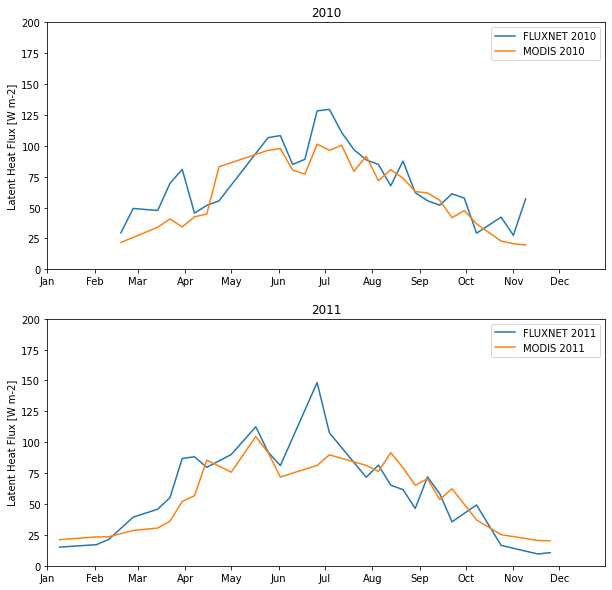

In [3]:
# Call the plot functions with the years to be plotted

oensingen.plot_values(2010, 2011)

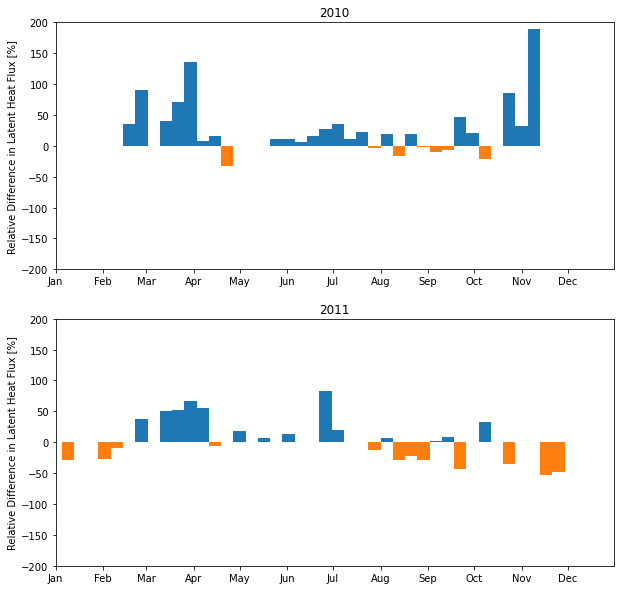

In [4]:
# Call the plot functions with the years to be plotted
#     mode: 'rel' or 'abs'
#     base: 'FLUXNET' or 'MODIS'

oensingen.plot_deltas(2010, 2011, mode='rel', base='FLUXNET')